<a href="https://colab.research.google.com/github/khagerthey/VIS1/blob/main/Glass_vs_Plastic_Merge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

I am currently employed by a food manufacturing business. At this facility we produce sauces, dressing, and salsas for well-known brands. An escalating problem we’re experiencing is glass breakages. Glass breakages are costly, dangerous, and time consuming. It’s apparent to quickly find the cause and a solution to this on-going issue.

My manager and I share the hypothesis that the root cause of the breakages is thermal shock. For this assignment I will be investigating a possible solution of substituting our glass jars for plastic.

Plastic is a cheaper alternative, more durable, and requires less maintenance. Plastic would eliminate the glass-breakage problem entirely, or at least reduce it significantly if it were only partially transitioned to replace the most breakable glass. 

I will be using multiple sources for this project. 



My first source is a Scientific Status Summary, which provided data on packaging generated through the span of several years:
https://www.researchgate.net/publication/5850700_Food_PackagingRoles_Materials_and_Environmental_Issues

Second sources provided price percentage increase throughout the years:
Glass- https://data.nasdaq.com/data/FRED/PCU32723272-producer-price-index-by-industry-glass-and-glass-product-manufacturing
Plastic- https://data.nasdaq.com/data/FRED/ID3923-export-harmonized-system-plastic-articles-for-conveyence-of-packing-goods-discontinued

My third source comes from my current employer. I referenced budget reports of previous production years and a projection of the 2023 calendar year. I have linked the budget for 2022 for reference. All personal information and business names have been removed. For privacy reasons, I am not approved to link all budget reports used in this project:
https://docs.google.com/spreadsheets/d/1T1sYPbftPsiexkaeBjQxuU3Ei8g2__k4/edit?usp=sharing&ouid=116386637706804625653&rtpof=true&sd=true


In [1]:

import time, os, sys, re
import zipfile, json, datetime, string 
import numpy as np
from statistics import *

import matplotlib.pyplot as plt 
import pandas as pd
import pandas_datareader as pdr
from pandas_datareader import wb
from pandas.io.formats.style import Styler

import urllib                                                 

from google.colab import files

import webbrowser                                                                      
import folium as f                                                                     
from folium.plugins import MarkerCluster, HeatMap                                      

import seaborn as sns

from google.colab import data_table
data_table.enable_dataframe_formatter() 


My first data set is a table of glass price index percentages shown throughout the years. This is a data set I found on Nasdaq.com by searching for glass production packaging. I adjusted the column header "Value" to "Glass Price Index %" and averaged a yearly price index rather than monthly for sake of merging on date and clearity.

In [26]:
glass=pd.read_csv('https://raw.githubusercontent.com/khagerthey/VIS1/main/Glass%20price%20%25%20-%20Cleaned%20(2).csv')
glass


,Date,Glass Price Index %
0,2021,0.099254
1,2020,0.025830
2,2019,0.015060
3,2018,0.031728
4,2017,0.022138
5,2016,0.020996
6,2015,0.045122
7,2014,0.017227
8,2013,0.013121
9,2012,0.015958


The following dataset is also from Nasdaq.com, I found it while searching for plastic production packaging data. Again, I adjusted the column header "Value" to "Plastic Price Index %" and reduced the data from monthly to a yearly average for the sake of merging and clearity.

In [9]:
plastic=pd.read_csv('https://raw.githubusercontent.com/khagerthey/VIS1/main/Plastic%20price%20%25%20-%20Plastic%20price%20%25%20(4).csv')
plastic

,Date,Plastic Price Index %
0,2021,-0.007517
1,2020,0.012443
2,2019,0.001941
3,2018,0.000477
4,2017,0.002763
5,2016,-0.001588
6,2015,-0.001748
7,2014,0.000812
8,2013,0.000216
9,2012,0.000536


I am merging together the price indexes between glass and plastics over the years. This is to give a clear price comparison in material.

In [16]:
mergedPercent = pd.merge(glass, plastic, how='outer', on=['Date'],indicator=True)
mergedPercent 

,Date,Glass Price Index %,Plastic Price Index %,_merge
0,2021,0.099254,-0.007517,both
1,2020,0.025830,0.012443,both
2,2019,0.015060,0.001941,both
3,2018,0.031728,0.000477,both
4,2017,0.022138,0.002763,both
5,2016,0.020996,-0.001588,both
6,2015,0.045122,-0.001748,both
7,2014,0.017227,0.000812,both
8,2013,0.013121,0.000216,both
9,2012,0.015958,0.000536,both


Here I removed the data that did not match.

In [17]:
mergedPercent = pd.merge(glass, plastic, how='inner', on=['Date'],indicator=True)
mergedPercent 

,Date,Glass Price Index %,Plastic Price Index %,_merge
0,2021,0.099254,-0.007517,both
1,2020,0.025830,0.012443,both
2,2019,0.015060,0.001941,both
3,2018,0.031728,0.000477,both
4,2017,0.022138,0.002763,both
5,2016,0.020996,-0.001588,both
6,2015,0.045122,-0.001748,both
7,2014,0.017227,0.000812,both
8,2013,0.013121,0.000216,both
9,2012,0.015958,0.000536,both


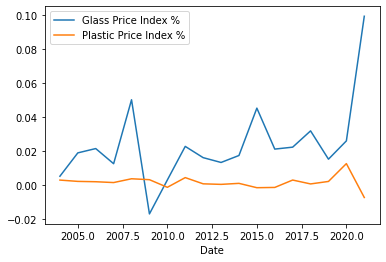

In [27]:
mergedPercent.plot(kind='line',x='Date')

As we can see displayed from both the table and line graph, glass prices have continously raised with the exception of 2009. The percentages show either an increase or decrease in price in comparision to the previous year. Plastic proves to trend cheaper than glass. Glass is a more costly material and it is also more expensive to ship, as it is heavier than plastic.

Now we will be looking at the total amount of weight of glass and plastic products generated in MSW (Municipal Solid Waste) from 1960 to 2005. This data was sourced from a Scientific Status Summary publication: Food Packaging - Roles, Materials, and Environmental Issues. 

Weight is measured in million tons. Headers have been changed from "Product" and "Weight (million tons)" to "Date", "Glass Weight", and "Plastic Weight". The dataset has also been reduced to only compare glass and plastic as they are the only materials of interest for this project and for the sake of merging.


In [13]:
weight=pd.read_csv('https://raw.githubusercontent.com/khagerthey/VIS1/main/Copy%20of%20Food%20Packaging%20-%20Roles%2C%20Materials%2C%20and%20Environmental%20Issues%20CLEANED%20-%20Weight%20Cleaned.csv')
weight

,Date,Glass Weight,Plastic Weight
0,1960,6.2,0.1
1,1970,11.9,2.1
2,1980,14.0,3.4
3,1990,11.8,6.9
4,2000,11.0,11.9
5,2003,10.6,12.9
6,2004,10.9,14.0
7,2005,10.9,13.7


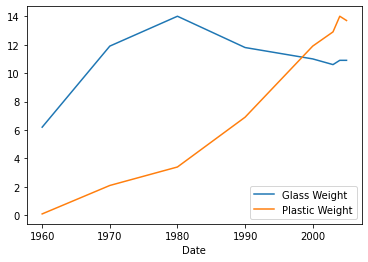

In [14]:
weight.plot(kind='line',x='Date')

Overtime the use of plastic has become more popular, especially transitioning from the 90s to the 2000s. The amount of glass has stayed consistant during this time, but the trend of plastic projects a steady increase.

The popularity of plastics in addition of its cheaper price makes it a good resource for business.

In [20]:
mergedWeight = pd.merge(weight, mergedPercent, how='outer', on=['Date'],indicator='exists')
mergedWeight 

,Date,Glass Weight,Plastic Weight,Glass Price Index %,Plastic Price Index %,_merge,exists
0,1960,6.2,0.1,NaN,NaN,NaN,left_only
1,1970,11.9,2.1,NaN,NaN,NaN,left_only
2,1980,14.0,3.4,NaN,NaN,NaN,left_only
3,1990,11.8,6.9,NaN,NaN,NaN,left_only
4,2000,11.0,11.9,NaN,NaN,NaN,left_only
5,2003,10.6,12.9,NaN,NaN,NaN,left_only
6,2004,10.9,14.0,0.005013,0.002744,both,both
7,2005,10.9,13.7,0.018766,0.001972,both,both
8,2021,NaN,NaN,0.099254,-0.007517,both,right_only
9,2020,NaN,NaN,0.025830,0.012443,both,right_only


Below is the data after removing what did not match.

In [18]:
mergedWeight = pd.merge(weight, mergedPercent, how='inner', on=['Date'],indicator='exists')
mergedWeight

,Date,Glass Weight,Plastic Weight,Glass Price Index %,Plastic Price Index %,_merge,exists
0,2004,10.9,14.0,0.005013,0.002744,both,both
1,2005,10.9,13.7,0.018766,0.001972,both,both


Weight compared to cost shows that the cheaper material is generated more. Both years had a much larger weight of plastic and a cheaper price alternative to glass.

The following are the averages of the amount of glass and plastic jars accounted for in the final product throughout the past 20 years. Note: the actual count of materials is higher than what is projected below due to breakages, product holds, and other complications which may have occurred during production.

Each case contains 12 jars of product.

In [19]:
count=pd.read_csv('https://raw.githubusercontent.com/khagerthey/VIS1/main/Glass%20Count%20Cleaned%20-%20Sheet1.csv')
count

,Date,Glass Cases (12-pack),Plastic Cases (12-pack)
0,2023,5326000,3392000
1,2022,5458000,5087719
2,2021,5308000,4283000
3,2020,4872000,2033000
4,2019,5794000,4870000
5,2018,5638000,4001000
6,2017,6392000,6017000
7,2016,5982000,3796000
8,2015,5048000,4007000
9,2014,5395000,4990000


As seen above, this company tends to produce more glass cases rather than plastics. With the expection of one year in which a plant devoted to a specific brand's dressing which is packaged in plastic ( and then unfortunately closed down later that year).

Below I have merged today all three data sources. This chart shows the amount of jars (glass and plastic) my company consumes yearly, comparision weight of the material being generated across the country, and the cost of these materials.

This data was provided by the company via yearly budget reports. For privacy, product details and the company name have been removed. This dataset has been reduced to only show the total glass and plastic finished goods case counts. Headers have been adjusted for the sake of merging.

For the purpose of full comparision, below includes all present and missing data.

In [21]:
mergedCount = pd.merge(count, mergedWeight, how='outer', on=['Date'], indicator='accounted')
mergedCount

,Date,Glass Cases (12-pack),Plastic Cases (12-pack),Glass Weight,Plastic Weight,Glass Price Index %,Plastic Price Index %,_merge,exists,accounted
0,2023,5326000.0,3392000.0,NaN,NaN,NaN,NaN,NaN,NaN,left_only
1,2022,5458000.0,5087719.0,NaN,NaN,NaN,NaN,NaN,NaN,left_only
2,2021,5308000.0,4283000.0,NaN,NaN,0.099254,-0.007517,both,right_only,both
3,2020,4872000.0,2033000.0,NaN,NaN,0.025830,0.012443,both,right_only,both
4,2019,5794000.0,4870000.0,NaN,NaN,0.015060,0.001941,both,right_only,both
5,2018,5638000.0,4001000.0,NaN,NaN,0.031728,0.000477,both,right_only,both
6,2017,6392000.0,6017000.0,NaN,NaN,0.022138,0.002763,both,right_only,both
7,2016,5982000.0,3796000.0,NaN,NaN,0.020996,-0.001588,both,right_only,both
8,2015,5048000.0,4007000.0,NaN,NaN,0.045122,-0.001748,both,right_only,both
9,2014,5395000.0,4990000.0,NaN,NaN,0.017227,0.000812,both,right_only,both


Below shows the same variables with the missing data removed for a cleaner comparision.

In [25]:
mergedCount = pd.merge(count, mergedWeight, how='inner', on=['Date'], indicator='accounted')
mergedCount

,Date,Glass Cases (12-pack),Plastic Cases (12-pack),Glass Weight,Plastic Weight,Glass Price Index %,Plastic Price Index %,_merge,exists,accounted
0,2021,5308000,4283000,NaN,NaN,0.099254,-0.007517,both,right_only,both
1,2020,4872000,2033000,NaN,NaN,0.025830,0.012443,both,right_only,both
2,2019,5794000,4870000,NaN,NaN,0.015060,0.001941,both,right_only,both
3,2018,5638000,4001000,NaN,NaN,0.031728,0.000477,both,right_only,both
4,2017,6392000,6017000,NaN,NaN,0.022138,0.002763,both,right_only,both
5,2016,5982000,3796000,NaN,NaN,0.020996,-0.001588,both,right_only,both
6,2015,5048000,4007000,NaN,NaN,0.045122,-0.001748,both,right_only,both
7,2014,5395000,4990000,NaN,NaN,0.017227,0.000812,both,right_only,both
8,2013,4997000,4012000,NaN,NaN,0.013121,0.000216,both,right_only,both
9,2012,4891000,3920000,NaN,NaN,0.015958,0.000536,both,right_only,both


In conclusion, plastic is a viable alternative for this company. Plastic is likely to remain cheaper than glass and is more durable, thus reducing breakages. Plastic packaging has become more popular and normalized throughout the years, meaning the company will less likely stand out by converting. 

In the next assignment, I will be investigating if it would be more cost effective to expand glass heating facilities to reduce thermal shock rather than converting to plastic. 
